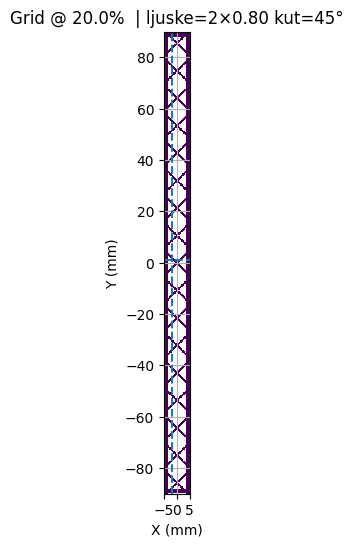

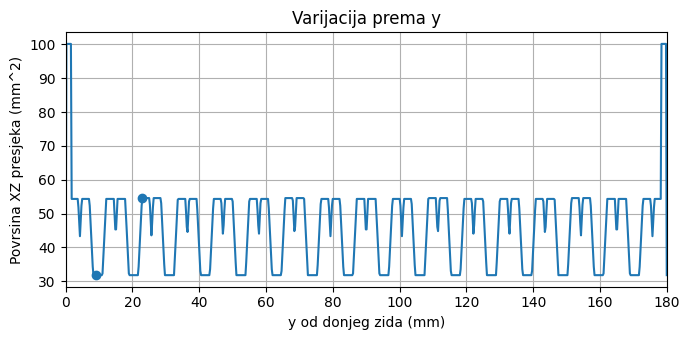

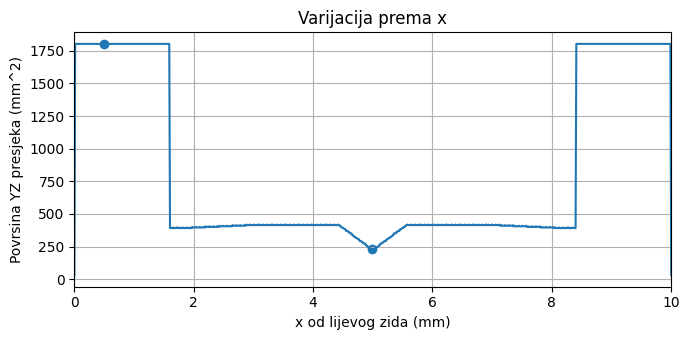

==== Grid ispuna 20.0% ====
XY ukupna povrsina     = 841.3408 mm^2
  Povrsina ljuski      = 594.4840 mm^2
  Povrsina ispune      = 246.8568 mm^2
-- Presjeci kroz Z (uzorak konstantan po Z) --
Duzina po X @ y=1.000 mm: 5.4318 mm
Duzina po Y @ x=-2.000 mm: 41.9024 mm
Povrsina XZ @ y=1.000: 54.3179 mm^2  (Z=10.000 mm)
Povrsina YZ @ x=-2.000: 419.0238 mm^2  (Z=10.000 mm)
MIN XZ povrsina = 31.7897 mm^2 @ y = 9.011 mm
MAX XZ povrsina = 54.5682 mm^2 @ y = 22.979 mm
MIN YZ povrsina = 229.7872 mm^2 @ x = 4.981 mm
MAX YZ povrsina = 1802.2528 mm^2 @ x = 0.501 mm

A_xz(y=1mm) = 54.31789737171478 mm^2
A_yz(x=-2mm) = 419.02377972464365 mm^2
MIN/MAX XZ: 31.78973717146441 @ y = 9.01126408010012 mm  |   54.56821026282867 @ y = 22.97872340425532 mm
MIN/MAX YZ: 229.78723404254652 @ x = 4.981226533166458 mm  |   1802.2528160199727 @ x = 0.5006257822277851 mm


In [115]:
import numpy as np
import matplotlib.pyplot as plt

def _udaljenost_mod(u, razmak):
    r = np.mod(u, razmak)
    return np.minimum(r, razmak - r)

def _pravocrtna_maska(XX, YY, razmak, sirina_linije, kut_stupnjevi=0.0, faza=0.0):
    th = np.deg2rad(kut_stupnjevi)
    u =  XX * np.cos(th) + YY * np.sin(th)
    dist = _udaljenost_mod(u + faza, razmak)
    return dist <= (sirina_linije / 2.0)

def _razmak_za_gustocu_mreze(sirina_linije, f):
    f = float(np.clip(f, 0.0, 1.0))
    if f <= 0.0:
        return np.inf
    if f >= 1.0:
        return sirina_linije
    r = 1.0 - np.sqrt(1.0 - f)
    return sirina_linije / r

def izracun_povrsine(XX, YY, maska):
    if not np.any(maska):
        return {"A": 0.0}
    dx = XX[0, 1] - XX[0, 0]
    dy = YY[1, 0] - YY[0, 0]
    dA = dx * dy
    A = float(np.count_nonzero(maska) * dA)
    return {"A": A}

def prusa_mreza_ili_pravocrtna(
    sirina, visina,
    udio_ispune,
    sirina_linije=0.42,
    slojevi_ljuske=2,
    osnovni_kut_ispune_stupnjevi=45.0,
    mreza=True,
    z_visina=0.0,        
    faza_po_mm=0.0,
    # Poprečni presjeci kroz Z
    z_visina_objekta=None,  
    y_ravnina=0.0,          
    x_ravnina=0.0,          
    N=800,
    graficki_prikaz=True,
    detaljno=True
):
    xs = np.linspace(-sirina/2,  sirina/2,  N)
    ys = np.linspace(-visina/2, visina/2, N)
    XX, YY = np.meshgrid(xs, ys)

    shell_mask = np.zeros_like(XX, dtype=bool)
    for i in range(slojevi_ljuske):
        off = (i + 0.5) * sirina_linije
        shell_mask |= np.abs(XX - (-sirina/2  + off)) <= (sirina_linije / 2)
        shell_mask |= np.abs(XX - ( +sirina/2  - off)) <= (sirina_linije / 2)
        shell_mask |= np.abs(YY - (-visina/2 + off)) <= (sirina_linije / 2)
        shell_mask |= np.abs(YY - ( +visina/2 - off)) <= (sirina_linije / 2)

    unutarnji_pomak = slojevi_ljuske * sirina_linije
    unutarnji_pravokutnik = (
        (np.abs(XX) <= (sirina/2  - unutarnji_pomak)) &
        (np.abs(YY) <= (visina/2 - unutarnji_pomak))
    )

    if udio_ispune <= 0.0:
        infill_mask = np.zeros_like(XX, dtype=bool)
    elif udio_ispune >= 1.0:
        razmak = sirina_linije
        maske = []
        kutevi = [osnovni_kut_ispune_stupnjevi] + ([osnovni_kut_ispune_stupnjevi + 90] if mreza else [])
        faza = faza_po_mm * z_visina
        for a in kutevi:
            maske.append(_pravocrtna_maska(XX, YY, razmak, sirina_linije, kut_stupnjevi=a, faza=faza))
        infill_mask = np.logical_or.reduce(maske) & unutarnji_pravokutnik
    else:
        razmak = _razmak_za_gustocu_mreze(sirina_linije, udio_ispune) if mreza \
                 else sirina_linije / udio_ispune
        maske = []
        kutevi = [osnovni_kut_ispune_stupnjevi] + ([osnovni_kut_ispune_stupnjevi + 90] if mreza else [])
        faza = faza_po_mm * z_visina
        for a in kutevi:
            maske.append(_pravocrtna_maska(XX, YY, razmak, sirina_linije, kut_stupnjevi=a, faza=faza))
        infill_mask = np.logical_or.reduce(maske) & unutarnji_pravokutnik

    konacna_maska = shell_mask | infill_mask

    if graficki_prikaz:
        plt.figure(figsize=(6, 6))
        img = np.where(konacna_maska, 1.0, np.nan)
        plt.imshow(img, origin='lower',
                   extent=[-sirina/2, sirina/2, -visina/2, visina/2],
                   interpolation='nearest')
        naslov = "Grid" if mreza else "Pravocrtna"
        plt.title(f"{naslov} @ {udio_ispune*100:.1f}%  | ljuske={slojevi_ljuske}×{sirina_linije:.2f} kut={osnovni_kut_ispune_stupnjevi:.0f}°")
        plt.xlabel("X (mm)")
        plt.ylabel("Y (mm)")
        plt.gca().set_aspect('equal', 'box')
        plt.grid(True)
        # vodilice
        plt.hlines(y_ravnina, -sirina/2, sirina/2, linestyles='--')
        plt.vlines(x_ravnina, -visina/2, visina/2, linestyles='--')
        plt.show()

    total = izracun_povrsine(XX, YY, konacna_maska)
    ljuske = izracun_povrsine(XX, YY, shell_mask)
    A_ispuna = total["A"] - ljuske["A"]

    dx = XX[0, 1] - XX[0, 0]
    dy = YY[1, 0] - YY[0, 0]
    ys_centered = YY[:, 0]
    xs_centered = XX[0, :]
    row = int(np.argmin(np.abs(ys_centered - y_ravnina)))
    col = int(np.argmin(np.abs(xs_centered - x_ravnina)))

    duzina_x_na_y = float(np.count_nonzero(konacna_maska[row, :]) * dx)
    duzina_y_na_x = float(np.count_nonzero(konacna_maska[:, col]) * dy)

    povrsina_xz_na_y = None
    povrsina_yz_na_x = None
    if z_visina_objekta is not None and z_visina_objekta > 0:
        povrsina_xz_na_y = duzina_x_na_y * z_visina_objekta
        povrsina_yz_na_x = duzina_y_na_x * z_visina_objekta

    duzina_x_vs_y = np.count_nonzero(konacna_maska, axis=1) * dx
    duzina_y_vs_x = np.count_nonzero(konacna_maska, axis=0) * dy

    if z_visina_objekta is not None and z_visina_objekta > 0:
        povrsina_xz_vs_y = duzina_x_vs_y * z_visina_objekta
        povrsina_yz_vs_x = duzina_y_vs_x * z_visina_objekta
        y_oznaka = "Povrsina XZ presjeka (mm^2)"
        x_oznaka = "Povrsina YZ presjeka (mm^2)"
    else:
        povrsina_xz_vs_y = duzina_x_vs_y
        povrsina_yz_vs_x = duzina_y_vs_x
        y_oznaka = "Duzina po X (mm)  [postavi z_visina_objekta za povrsinu]"
        x_oznaka = "Duzina po Y (mm)  [postavi z_visina_objekta za povrsinu]"

    y_os_0_do_H = ys_centered + visina/2.0  # 0 .. H
    x_os_0_do_W = xs_centered + sirina/2.0  # 0 .. W

    # ==== NOVO: minimumi i maksimumi za XZ i YZ (samo srednji dio) ====
    # definiraj margine koje ćeš izbaciti (npr. 5% s obje strane)
    margin_frac = 0.05  
    n_y = len(povrsina_xz_vs_y)
    n_x = len(povrsina_yz_vs_x)
    start_y, end_y = int(margin_frac * n_y), int((1 - margin_frac) * n_y)
    start_x, end_x = int(margin_frac * n_x), int((1 - margin_frac) * n_x)
    
    # XZ presjek (po y)
    idx_min_xz = start_y + int(np.argmin(povrsina_xz_vs_y[start_y:end_y]))
    idx_max_xz = start_y + int(np.argmax(povrsina_xz_vs_y[start_y:end_y]))
    min_povrsina_xz = float(povrsina_xz_vs_y[idx_min_xz])
    max_povrsina_xz = float(povrsina_xz_vs_y[idx_max_xz])
    y_min_xz_mm = float(y_os_0_do_H[idx_min_xz])
    y_max_xz_mm = float(y_os_0_do_H[idx_max_xz])
    
    # YZ presjek (po x)
    idx_min_yz = start_x + int(np.argmin(povrsina_yz_vs_x[start_x:end_x]))
    idx_max_yz = start_x + int(np.argmax(povrsina_yz_vs_x[start_x:end_x]))
    min_povrsina_yz = float(povrsina_yz_vs_x[idx_min_yz])
    max_povrsina_yz = float(povrsina_yz_vs_x[idx_max_yz])
    x_min_yz_mm = float(x_os_0_do_W[idx_min_yz])
    x_max_yz_mm = float(x_os_0_do_W[idx_max_yz])
    # ================================================================


    if graficki_prikaz:
        plt.figure(figsize=(7, 3.5))
        plt.plot(y_os_0_do_H, povrsina_xz_vs_y)
        plt.xlabel("y od donjeg zida (mm)")
        plt.ylabel(y_oznaka)
        plt.title("Varijacija prema y")
        plt.grid(True)
        plt.xlim(0, visina)
        # markeri min/max
        plt.scatter([y_min_xz_mm, y_max_xz_mm], [min_povrsina_xz, max_povrsina_xz])
        plt.tight_layout()
        plt.show()

        plt.figure(figsize=(7, 3.5))
        plt.plot(x_os_0_do_W, povrsina_yz_vs_x)
        plt.xlabel("x od lijevog zida (mm)")
        plt.ylabel(x_oznaka)
        plt.title("Varijacija prema x")
        plt.grid(True)
        plt.xlim(0, sirina)
        # markeri min/max
        plt.scatter([x_min_yz_mm, x_max_yz_mm], [min_povrsina_yz, max_povrsina_yz])
        plt.tight_layout()
        plt.show()

    if detaljno:
        print(f"==== {('Grid' if mreza else 'Pravocrtna')} ispuna {udio_ispune*100:.1f}% ====")
        print(f"XY ukupna povrsina     = {total['A']:.4f} mm^2")
        print(f"  Povrsina ljuski      = {ljuske['A']:.4f} mm^2")
        print(f"  Povrsina ispune      = {A_ispuna:.4f} mm^2")
        print(f"-- Presjeci kroz Z (uzorak konstantan po Z) --")
        print(f"Duzina po X @ y={y_ravnina:.3f} mm: {duzina_x_na_y:.4f} mm")
        print(f"Duzina po Y @ x={x_ravnina:.3f} mm: {duzina_y_na_x:.4f} mm")
        if povrsina_xz_na_y is not None:
            print(f"Povrsina XZ @ y={y_ravnina:.3f}: {povrsina_xz_na_y:.4f} mm^2  (Z={z_visina_objekta:.3f} mm)")
        if povrsina_yz_na_x is not None:
            print(f"Povrsina YZ @ x={x_ravnina:.3f}: {povrsina_yz_na_x:.4f} mm^2  (Z={z_visina_objekta:.3f} mm)")
        # NOVO: ispis min/max
        print(f"MIN XZ povrsina = {min_povrsina_xz:.4f} mm^2 @ y = {y_min_xz_mm:.3f} mm")
        print(f"MAX XZ povrsina = {max_povrsina_xz:.4f} mm^2 @ y = {y_max_xz_mm:.3f} mm")
        print(f"MIN YZ povrsina = {min_povrsina_yz:.4f} mm^2 @ x = {x_min_yz_mm:.3f} mm")
        print(f"MAX YZ povrsina = {max_povrsina_yz:.4f} mm^2 @ x = {x_max_yz_mm:.3f} mm")
        print()

    return {
        "maska": konacna_maska,
        "XX": XX, "YY": YY,
        "dx": dx, "dy": dy,
        "povrsina_ukupno_xy": total["A"],
        "povrsina_ljuske_xy": ljuske["A"],
        "povrsina_ispune_xy": A_ispuna,
        "duzina_x_na_y": duzina_x_na_y,
        "duzina_y_na_x": duzina_y_na_x,
        "povrsina_xz_na_y": povrsina_xz_na_y,
        "povrsina_yz_na_x": povrsina_yz_na_x,
        "y_os_mm": y_os_0_do_H,
        "x_os_mm": x_os_0_do_W,
        "povrsina_xz_vs_y": povrsina_xz_vs_y,
        "povrsina_yz_vs_x": povrsina_yz_vs_x,
        # NOVO: min/max rezultati
        "min_povrsina_xz": min_povrsina_xz,
        "max_povrsina_xz": max_povrsina_xz,
        "y_min_xz_mm": y_min_xz_mm,
        "y_max_xz_mm": y_max_xz_mm,
        "min_povrsina_yz": min_povrsina_yz,
        "max_povrsina_yz": max_povrsina_yz,
        "x_min_yz_mm": x_min_yz_mm,
        "x_max_yz_mm": x_max_yz_mm,
    }

# Konfiguracija
if __name__ == "__main__":
    W, H = 10, 180
    Z = 10
    res = prusa_mreza_ili_pravocrtna(
        sirina=W, visina=H,
        udio_ispune=0.2,
        sirina_linije=0.8,
        slojevi_ljuske=2,
        osnovni_kut_ispune_stupnjevi=45.0,
        mreza=True,
        z_visina_objekta=Z,  
        y_ravnina=+1.0,     
        x_ravnina=-2.0,      
        N=800,
        graficki_prikaz=True, detaljno=True
    )
    print("A_xz(y=1mm) =", res["povrsina_xz_na_y"], "mm^2")
    print("A_yz(x=-2mm) =", res["povrsina_yz_na_x"], "mm^2")
    print("MIN/MAX XZ:", res["min_povrsina_xz"], "@ y =", res["y_min_xz_mm"], "mm  |  ",
          res["max_povrsina_xz"], "@ y =", res["y_max_xz_mm"], "mm")
    print("MIN/MAX YZ:", res["min_povrsina_yz"], "@ x =", res["x_min_yz_mm"], "mm  |  ",
          res["max_povrsina_yz"], "@ x =", res["x_max_yz_mm"], "mm")
